In [66]:
from standardInclude import *

In [67]:
#path = "/home/jlab/g-2/caloTrackMatching/data/run2c/"; dataset='Run 2C'
path = "/home/jlab/g-2/caloTrackMatching/data/endgame/"; dataset='EndGame'
files = os.listdir(path)
print(files)
names = [x.split("_")[0] for x in files]
print(names)

fs = {}
for file in files:
    name = file.split("_")[0]
    fs[name] = r.TFile(path+file)
    fs[name].ls()

['clusters_eg.root', 'tracks_eg.root', 'matchedTracks_eg.root']
['clusters', 'tracks', 'matchedTracks']
TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root	
  KEY: TH3F	clusters13;1	clusters
  KEY: TH3F	randclusters13;1	time randomized clusters
  KEY: TH3F	clusters19;1	clusters
  KEY: TH3F	randclusters19;1	time randomized clusters
TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRadialFieldRand;1	Tracker 

In [68]:
allFitResults = {}

In [69]:
station = 12
calo = station+1

---

### First create a function which will act as a standard pool from which we can pull our fit functions, just for ease of switching between them

In [5]:
def fitfunc(choice, fitrange, params=None):
    tlow, thigh = fitrange
    if(choice is 0):
        func = r.TF1("func","[0] + [1] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
        func.SetParNames("C", "A", "#tau", "m")
        if(params is None):
            paramVec = [1,10,1,-0.0001,10]
        else:
            paramVec = params
        for i,xi in enumerate(paramVec):
            func.SetParameter(i,xi)
        return (func,paramVec)
    elif(choice is 1):
        func = r.TF1("func","pol1",tlow,thigh)
        func.SetParNames("C", "m")
        if(params is None):
            params = [1,-0.00001]
        for i,xi in enumerate(params):
            func.SetParameter(i,xi)
        return (func, params)
    else:
        print("Invalid choice")
        return -1

---

# Lets start with the tracker-only information


In [6]:
name = 'tracks'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRadialFieldRand;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time


In [7]:
trackerBeamPos = f.Get("trackerBeamPosRand").Clone()
trackerCaloPos = f.Get("trackerCaloPosRand").Clone()
trackerCaloPos_noRadialField = f.Get("trackerCaloPos_noRadialField").Clone()
trackerCaloPos_noRadialFieldRand = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

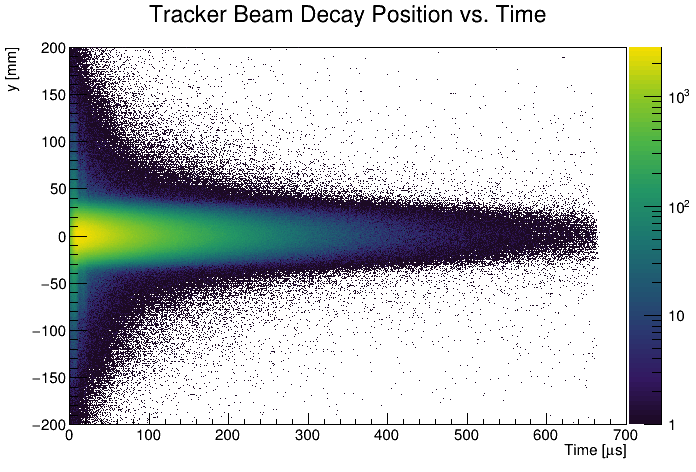

In [8]:
c = r.TCanvas()
#trackerBeamPos.Draw("lego2z")
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))

hi = trackerBeamPos.Project3D("yx").Clone()
hi.SetTitle("Tracker Beam Decay Position vs. Time; Time [#mus]; y [mm]")
hi.Draw("colz")
c.SetLogz()
c.Draw()

---

### Lets get the beam position vs. time for the selected station

In [9]:
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))
widthDict = getWidths(trackerBeamPos.Project3D("yx"))

In [10]:
tlow = 30
thigh = 500
func,paramVec = fitfunc(0, [tlow,thigh],[15,-170,0.00053,0.061]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'],nFit=2)
allFitResults[name+"_beam"] = fitresult

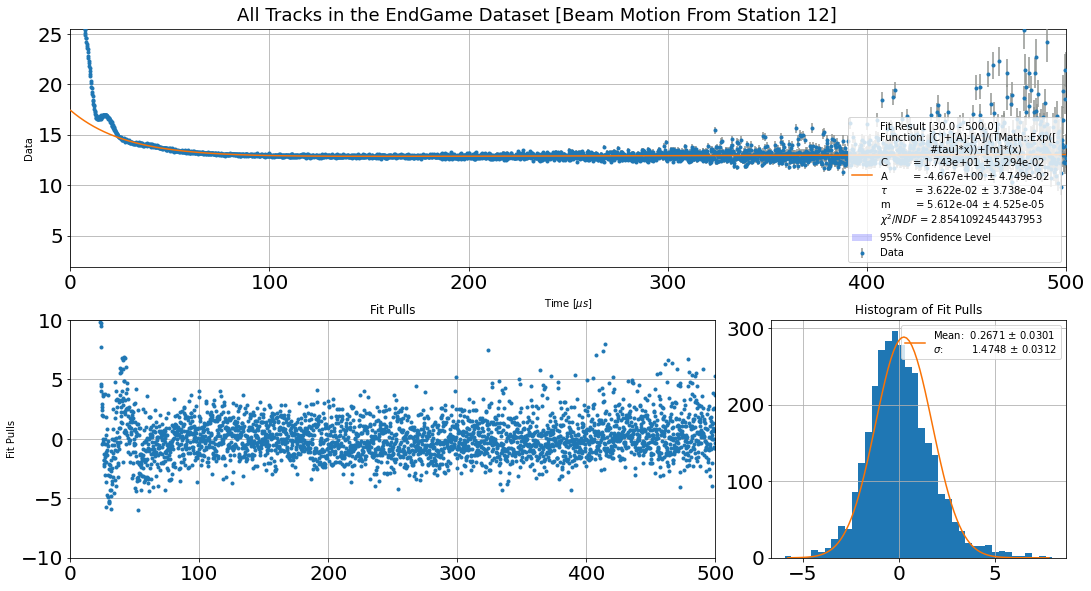

In [11]:
#fitresult.f.SetParameters(15,-170,0.00053,0.061)

fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Beam Motion From Station "+str(station)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(11,15)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

/home/jlab/g-2/fitting/python_fit.py:414: RuntimeWarning: Mean of empty slice
  mean_ri = np.nanmean(resid[i-runningAverage:i+runningAverage])


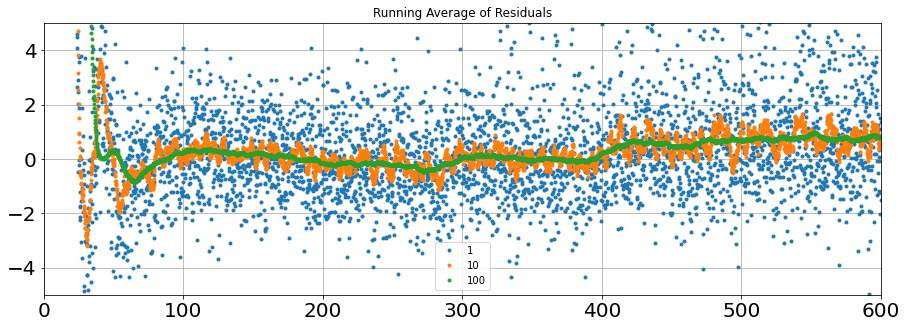

In [12]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(0,600)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [60, 300]


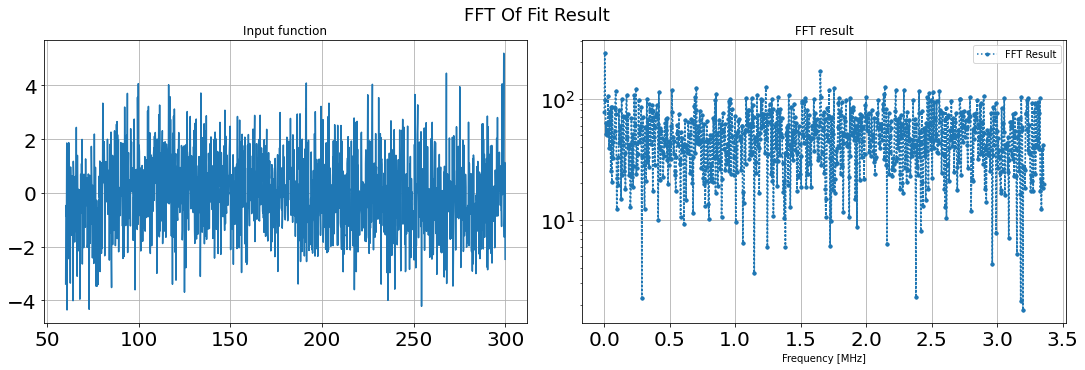

(array([ 0.        ,  0.00416859,  0.00833718, ..., -0.01250577,
        -0.00833718, -0.00416859]),
 array([ -77.15340228+0.00000000e+00j, -116.35316579-2.06637350e+02j,
         -97.34270788-4.50171226e+00j, ...,  -51.48992073-6.98586719e-02j,
         -97.34270788+4.50171226e+00j, -116.35316579+2.06637350e+02j]))

In [13]:
fitresult.fft([60,300],2)

---

### And the calo face position vs. time for the selected station

In [14]:
trackerCaloPos.GetZaxis().SetRange(trackerCaloPos.GetZaxis().FindBin(station),trackerCaloPos.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos.Project3D("yx"))

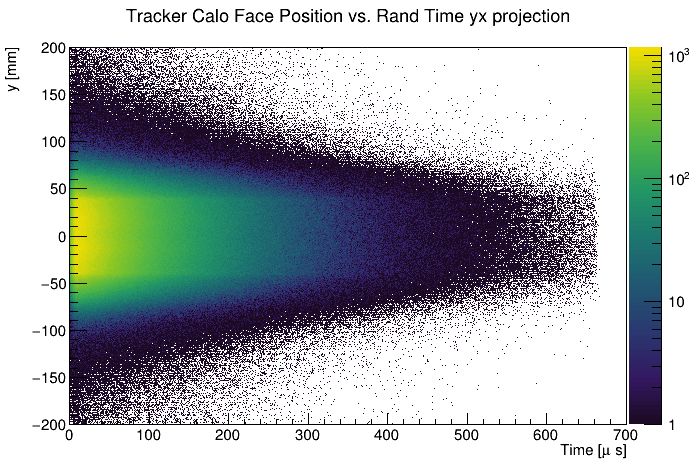

In [15]:
c = r.TCanvas()
hi = trackerCaloPos.Project3D("yx").Clone()
hi.Draw("colz")
c.SetLogz()
c.Draw()

In [16]:
tlow = 30
thigh = 500
func,paramVec = fitfunc(0, [tlow,thigh],[32, 3.5, 0.0005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_calo"] = fitresult

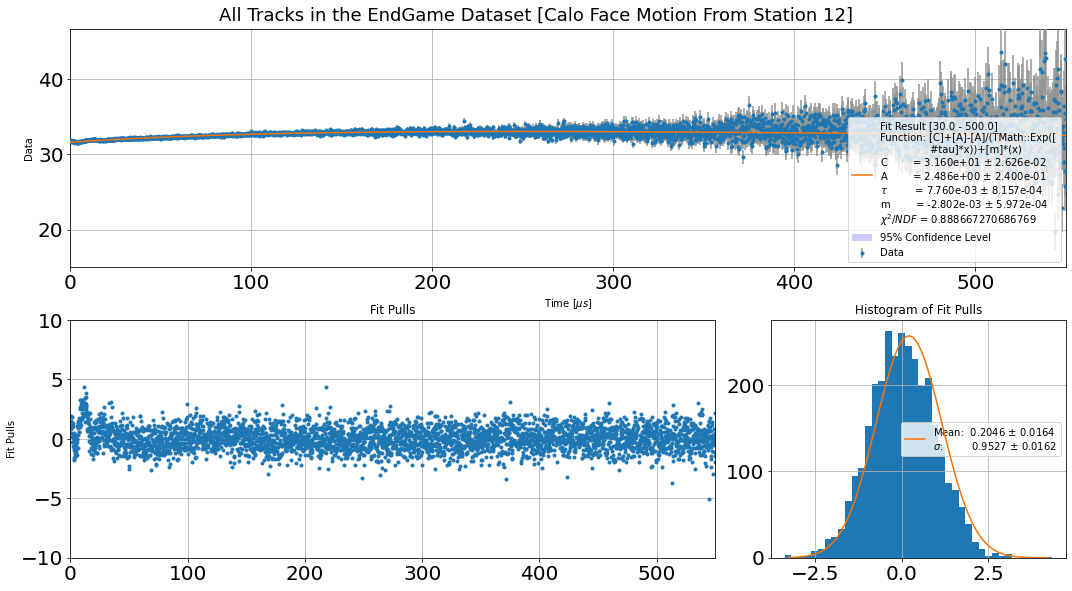

In [17]:
fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Calo Face Motion From Station "+str(station)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(30,35)
for i in range(2):
    ax[i].set_xlim(0,550)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

/home/jlab/g-2/fitting/python_fit.py:414: RuntimeWarning: Mean of empty slice
  mean_ri = np.nanmean(resid[i-runningAverage:i+runningAverage])


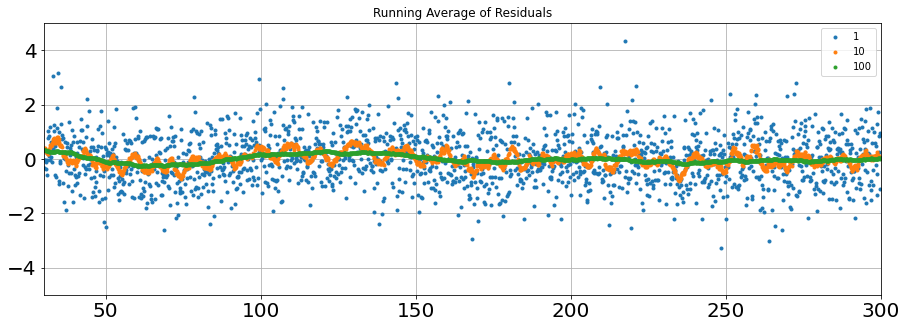

In [18]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [20, 300]


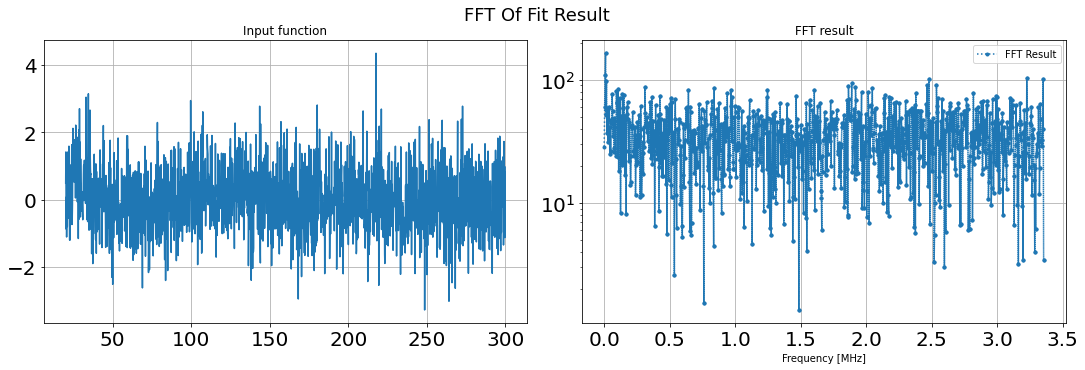

(array([ 0.        ,  0.00357181,  0.00714362, ..., -0.01071543,
        -0.00714362, -0.00357181]),
 array([ 28.60897919-7.10542736e-15j, -20.62829073-5.68953050e+01j,
         77.68587005+7.62050786e+01j, ..., 152.66672037+6.12580114e+01j,
         77.68587005-7.62050786e+01j, -20.62829073+5.68953050e+01j]))

In [19]:
fitresult.fft([20,300],2)

---

### Calo face position vs. time (from tracker, but ignoring radial field)

In [20]:
trackerCaloPos_noRadialFieldRand.GetZaxis().SetRange(
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station),
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_noRadialFieldRand.Project3D("yx"))

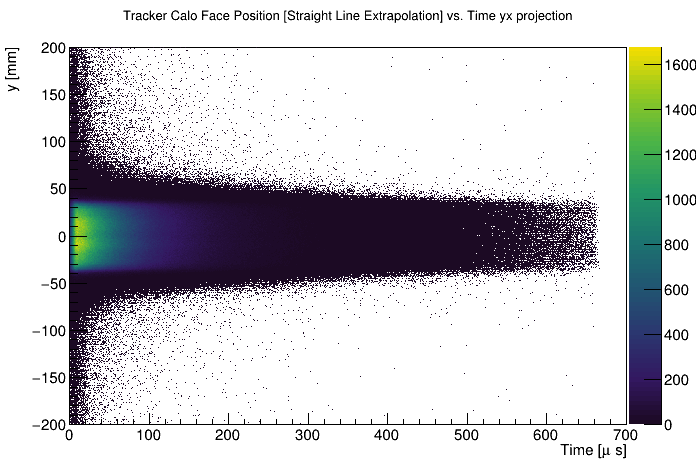

In [21]:
c = r.TCanvas()
trackerCaloPos_noRadialFieldRand.Project3D("yx").Draw("colz")
c.Draw()

In [22]:
tlow = 20
thigh = 600

func,paramVec = fitfunc(0, [tlow,thigh],[32, 3.5, 0.0005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_calo_noRadialField"] = fitresult

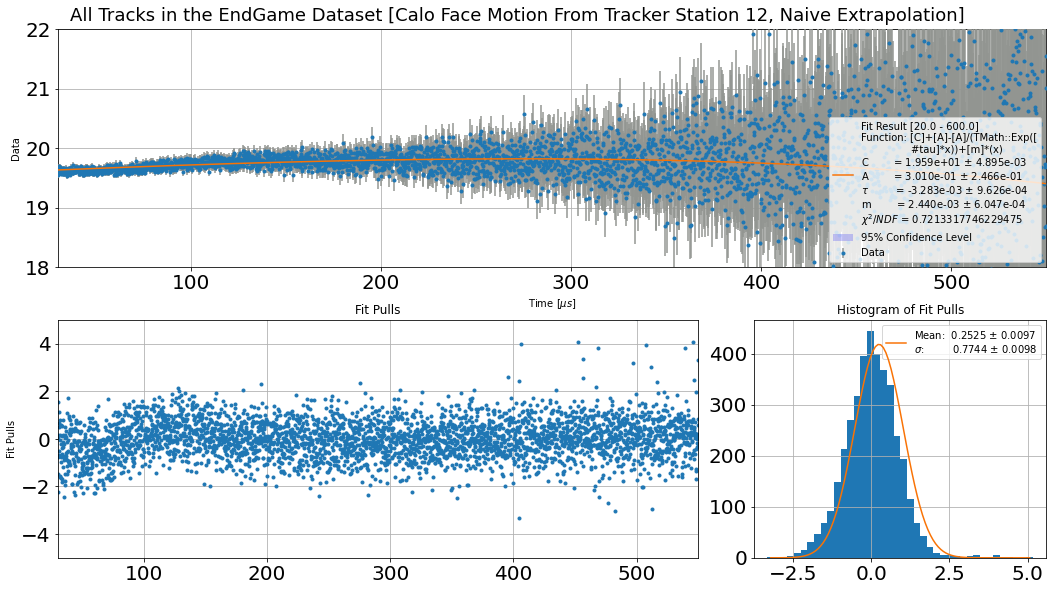

In [23]:
fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Calo Face Motion From Tracker Station "+str(station)+", Naive Extrapolation]", 
                        yrange=[None, [-5,5]], fmti=".", do_pulls=True)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(30,550)
ax[0].set_ylim(18,22)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

/home/jlab/g-2/fitting/python_fit.py:414: RuntimeWarning: Mean of empty slice
  mean_ri = np.nanmean(resid[i-runningAverage:i+runningAverage])


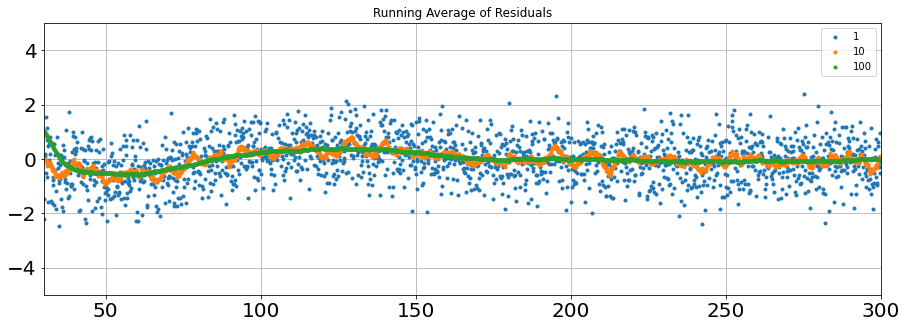

In [24]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [30, 300]


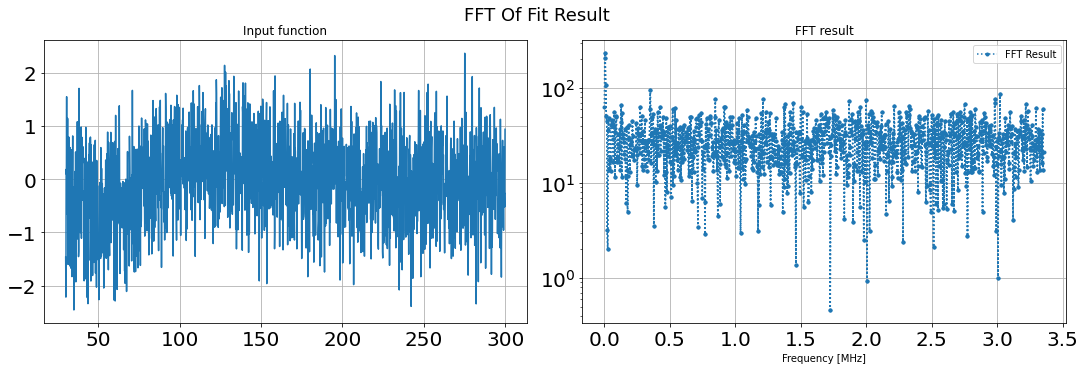

(array([ 0.        ,  0.00370388,  0.00740776, ..., -0.01111164,
        -0.00740776, -0.00370388]),
 array([ -62.40723125  +0.j        , -224.85322193 -58.36359528j,
         -77.44481748+194.11184476j, ...,   70.07446853 -83.30637604j,
         -77.44481748-194.11184476j, -224.85322193 +58.36359528j]))

In [25]:
fitresult.fft([30,300],2)

---

# And now the calo only information

In [26]:
name = 'clusters'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root	
  KEY: TH3F	clusters13;1	clusters
  KEY: TH3F	randclusters13;1	time randomized clusters
  KEY: TH3F	clusters19;1	clusters
  KEY: TH3F	randclusters19;1	time randomized clusters


In [27]:
clusters = f.Get("clusters"+str(calo)).Clone()
randclusters = f.Get("randclusters"+str(calo)).Clone()

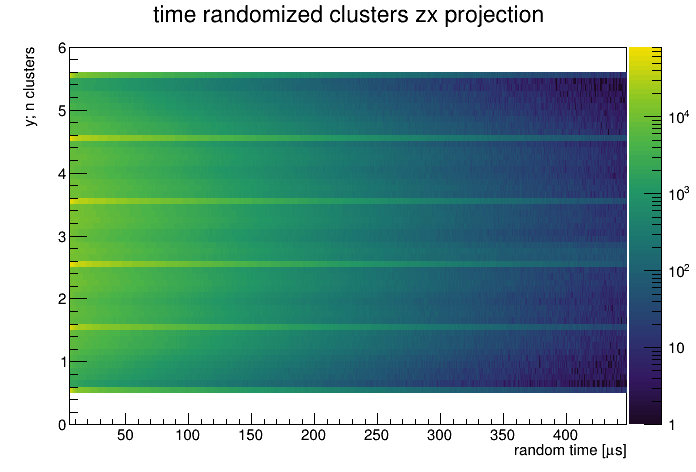

In [28]:
c = r.TCanvas()
randclusters.Project3D("zx").Draw("colz")
c.SetLogz()
c.Draw()

---
### Calo face position

In [29]:
randclusters.GetYaxis().SetRange(randclusters.GetYaxis().FindBin(1000),randclusters.GetYaxis().FindBin(2400))
widthDict = getWidths(randclusters.Project3D("zx"), scale=25, offset=3)

In [30]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(1, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_calo"] = fitresult

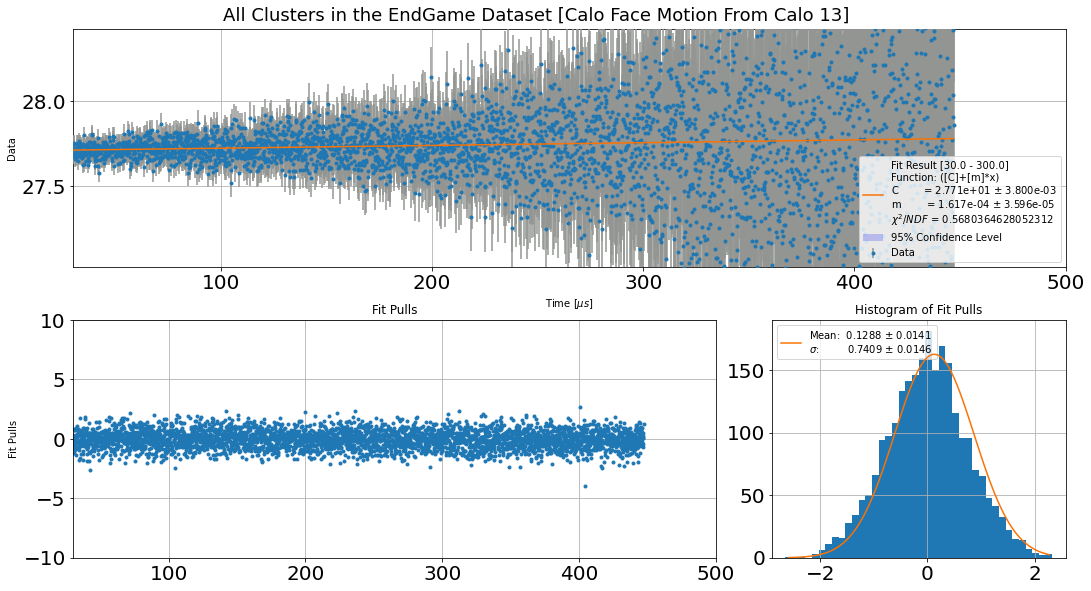

In [31]:
fig,ax = fitresult.draw("All Clusters in the "+dataset+" Dataset [Calo Face Motion From Calo "+str(calo)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(-2,2)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(30,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

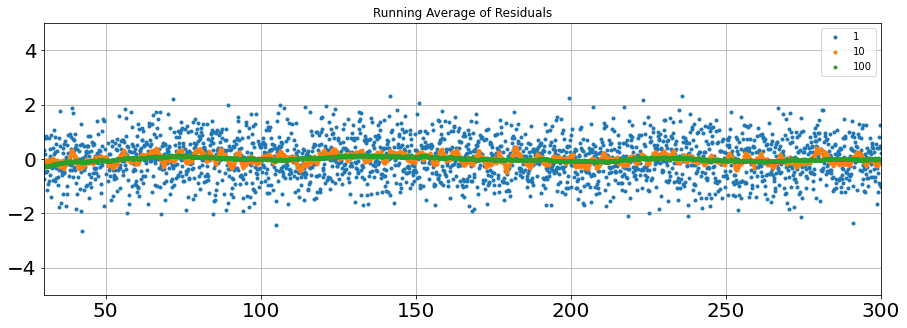

In [32]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [30, 300]


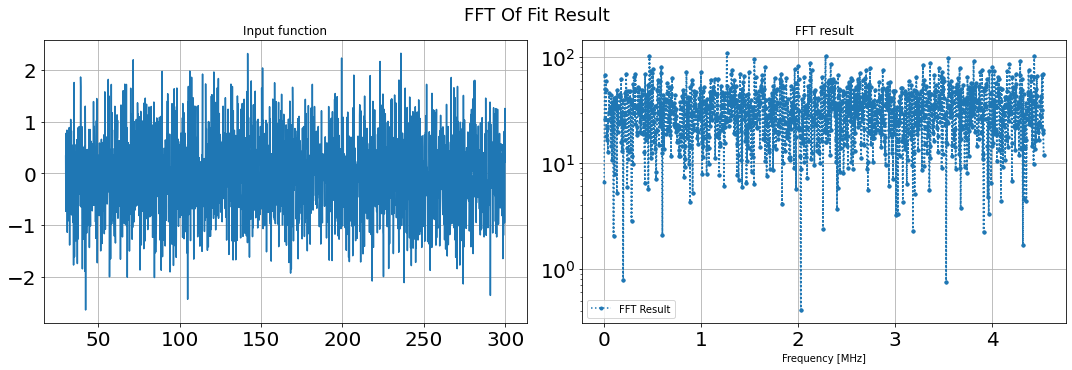

(array([ 0.        ,  0.0037032 ,  0.00740639, ..., -0.01110959,
        -0.00740639, -0.0037032 ]),
 array([ -6.68445356+7.10542736e-15j, -36.29929674-5.71145407e+01j,
        -16.16618356+2.04878837e+01j, ..., -28.88706677+4.13064972e+01j,
        -16.16618356-2.04878837e+01j, -36.29929674+5.71145407e+01j]))

In [33]:
fitresult.fft([30,300],2)

---

# And finally the calo-matched information

In [34]:
name = 'matchedTracks'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/matchedTracks_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/matchedTracks_eg.root	
  OBJ: TH3I	trackerBeamPosRand	Tracker Beam Position vs. Rand Time : 0 at: 0x55df60df9f20
  OBJ: TH3I	trackerCaloPosRand	Tracker Calo Face Position vs. Rand Time : 0 at: 0x55df60df1980
  OBJ: TH3I	trackerCaloPos_noRadialField	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time : 0 at: 0x55df60dfec40
  OBJ: TH3I	trackerCaloPos_noRadialFieldRand	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time : 0 at: 0x55df60df3360
  OBJ: TH2D	trackerBeamPosRand_yx	Tracker Beam Position vs. Rand Time yx projection : 0 at: 0x55df60fac180
  OBJ: TH1D		Tracker Beam Position vs. Rand Time yx projection : 0 at: 0x55df611f99b0
  OBJ: TH2D	trackerCaloPosRand_yx	Tracker Calo Face Position vs. Rand Time yx projection : 0 at: 0x55df61e15de0
  OBJ: TH2D	trackerCaloPosRand_yx	Tracker Calo Face Position vs. Rand Time yx projection :

In [35]:
trackerBeamPos_match = f.Get("trackerBeamPosRand").Clone()
trackerCaloPos_match = f.Get("trackerCaloPosRand").Clone()
caloCaloPos_match = f.Get("caloCaloPosRand").Clone()
trackerCaloPos_noRadialField_match = f.Get("trackerCaloPos_noRadialField").Clone()
trackerCaloPos_noRadialFieldRand_match = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

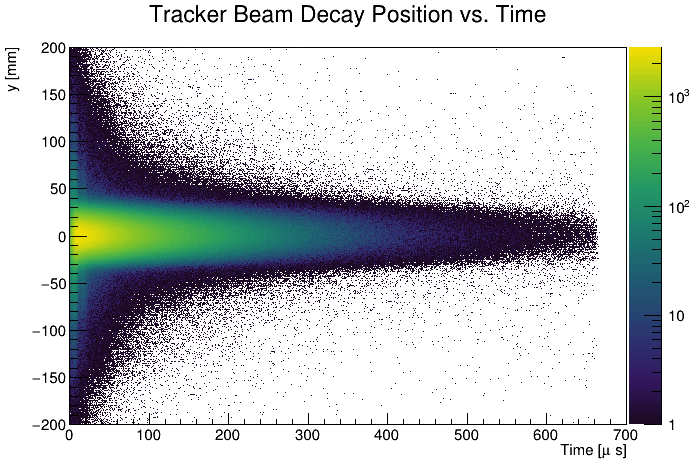

In [36]:
c = r.TCanvas()
#trackerBeamPos.Draw("lego2z")
trackerBeamPos_match.GetZaxis().SetRange(trackerBeamPos_match.GetZaxis().FindBin(station),
                                         trackerBeamPos_match.GetZaxis().FindBin(station))

hi = trackerBeamPos_match.Project3D("yx").Clone()
hi.SetTitle("Tracker Beam Decay Position vs. Time")
hi.Draw("colz")
c.SetLogz()
c.Draw()

---

### Beam position vs. time

In [37]:
trackerBeamPos_match.GetZaxis().SetRange(trackerBeamPos_match.GetZaxis().FindBin(station),
                                         trackerBeamPos_match.GetZaxis().FindBin(station))
widthDict = getWidths(trackerBeamPos_match.Project3D("yx"))

In [38]:
tlow = 30
thigh = 500

func,paramVec = fitfunc(0, [tlow,thigh],[15,-170,0.00053,0.061]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_beam"] = fitresult

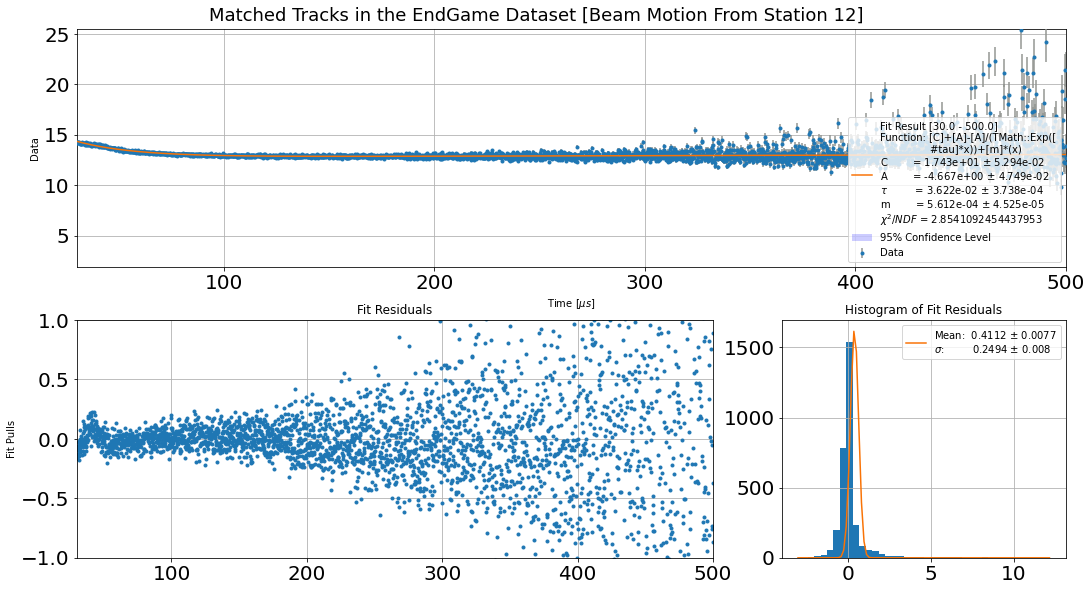

In [39]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Beam Motion From Station "+str(station)+"]", 
                        yrange=[None, [-1,1]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(30,500)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.show()

---

### Calo face position vs. time (from tracker)

In [40]:
trackerCaloPos_match.GetZaxis().SetRange(trackerCaloPos_match.GetZaxis().FindBin(station),
                                         trackerCaloPos_match.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_match.Project3D("yx"))

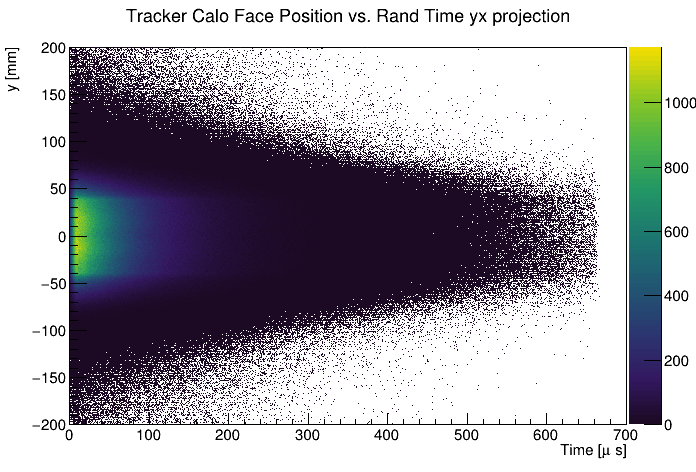

In [41]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
trackerCaloPos_match.Project3D("yx").Draw("colz")
trackerCaloPos_match.SetTitle("Normal Extrapolation to Calo Face")
c.Draw()

In [42]:
tlow = 30
thigh = 500

func,paramVec = fitfunc(0, [tlow,thigh],[32, 3.5, 0.0005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_calo"] = fitresult

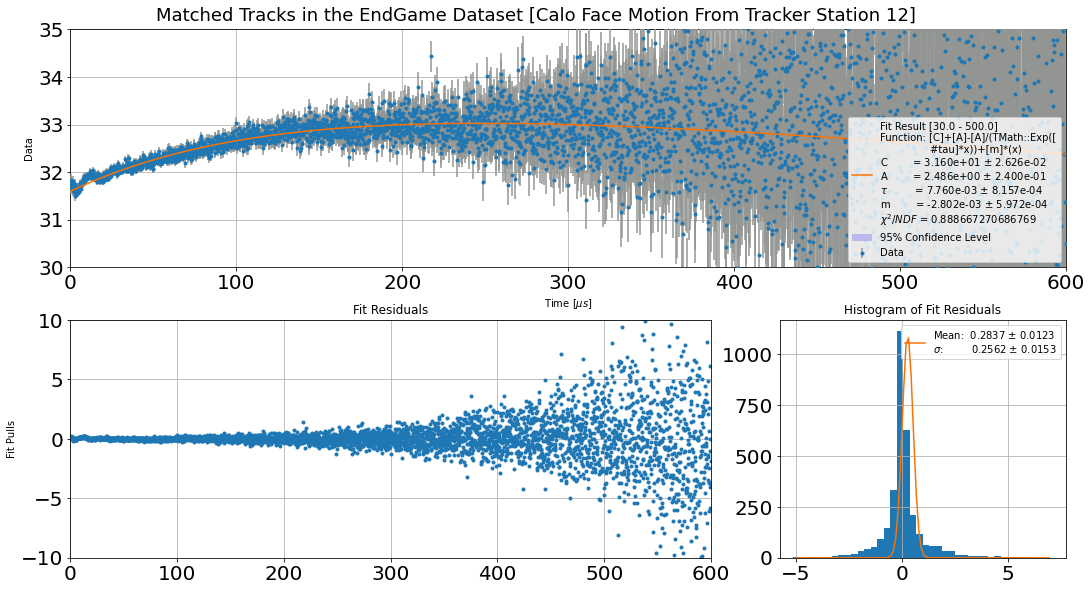

In [43]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Calo Face Motion From Tracker Station "+str(station)+"]", 
                        yrange=[[30,35], [-10,10]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,600)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

---

### Calo face position vs. time (from tracker, but ignoring radial field)

In [44]:
trackerCaloPos_noRadialFieldRand_match.GetZaxis().SetRange(
    trackerCaloPos_noRadialFieldRand_match.GetZaxis().FindBin(station),
    trackerCaloPos_noRadialFieldRand_match.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_noRadialFieldRand_match.Project3D("yx"))

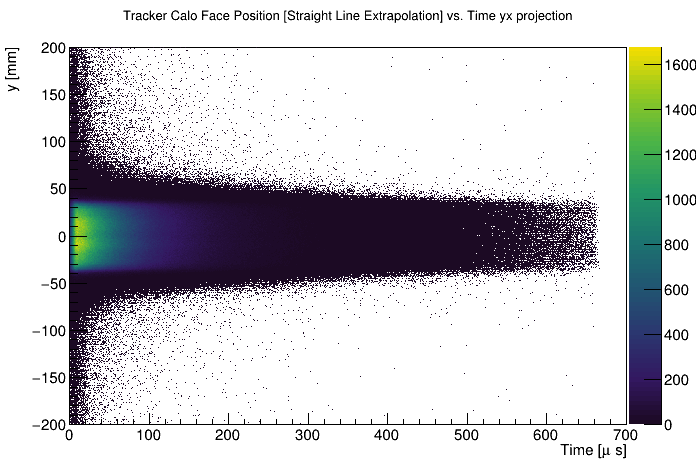

In [45]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
trackerCaloPos_noRadialFieldRand_match.Project3D("yx").Draw("colz")
c.Draw()

In [46]:
tlow = 30
thigh = 600

func,paramVec = fitfunc(0, [tlow,thigh], [32, 3.5, 0.0005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_calo_noRadialField"] = fitresult

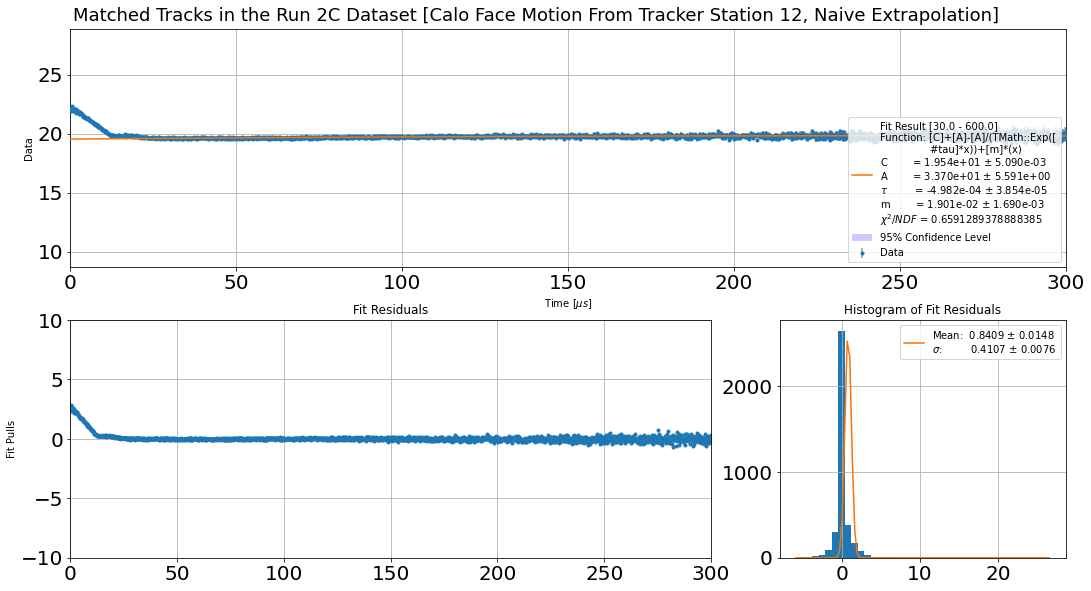

In [47]:
fig,ax = fitresult.draw("Matched Tracks in the Run 2C Dataset [Calo Face Motion From Tracker Station "+str(station)+", Naive Extrapolation]", 
                        yrange=[None, [-10,10]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,300)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

---

### Calo face position vs. time (from clusters)

In [48]:
caloCaloPos_match.GetZaxis().SetRange(caloCaloPos_match.GetZaxis().FindBin(station),
                                      caloCaloPos_match.GetZaxis().FindBin(station))
widthDict = getWidths(caloCaloPos_match.Project3D("yx"))

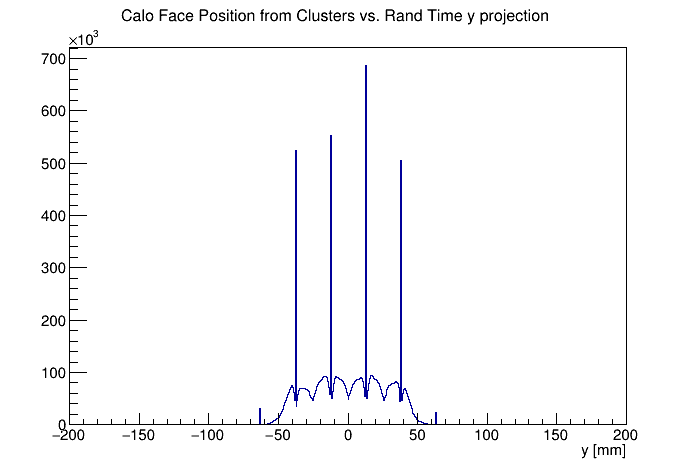

In [49]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
caloCaloPos_match.Project3D("y").Draw("colz")
c.Draw()

In [50]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(1, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_clusters"] = fitresult

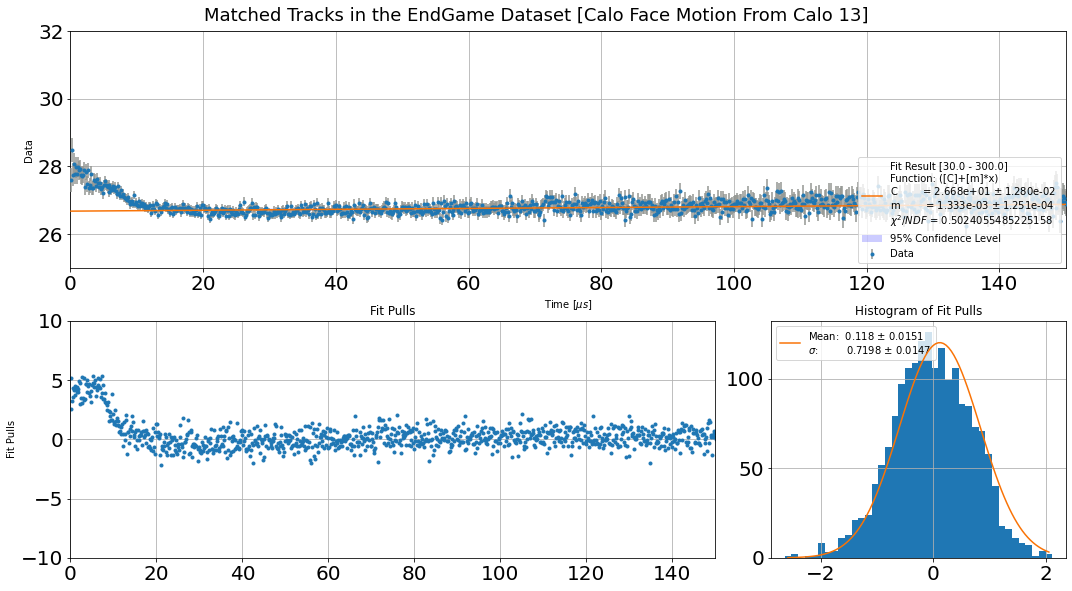

In [51]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Calo Face Motion From Calo "+str(calo)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
ax[0].set_ylim(25,32)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(0,150)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

---

# Now lets compare the fit results from these datasets

In [52]:
print(allFitResults)

{'tracks_beam': <python_fit.fitVector object at 0x7f1e6c569250>, 'tracks_calo': <python_fit.fitVector object at 0x7f1e676126d0>, 'tracks_calo_noRadialField': <python_fit.fitVector object at 0x7f1e71a925d0>, 'clusters_calo': <python_fit.fitVector object at 0x7f1e67766210>, 'matchedTracks_beam': <python_fit.fitVector object at 0x7f1e67a45990>, 'matchedTracks_calo': <python_fit.fitVector object at 0x7f1e71b07890>, 'matchedTracks_calo_noRadialField': <python_fit.fitVector object at 0x7f1e679e2c50>, 'matchedTracks_clusters': <python_fit.fitVector object at 0x7f1e711cd310>}


In [53]:
pars = []
parErrs = []
fitnames = []
allNames = []

for name,fit in allFitResults.items():
    print(name)
    fitnames.append(name)
    pars.append(fit.pars)
    parErrs.append(fit.parErrs)
    allNames.append( fit.parNames() )
print(allNames)

tracks_beam
tracks_calo
tracks_calo_noRadialField
clusters_calo
matchedTracks_beam
matchedTracks_calo
matchedTracks_calo_noRadialField
matchedTracks_clusters
[['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'm']]


In [54]:
parDict = {}
parErrDict = {}
histNames = {}
for names in allNames:
    for name in names:
        parDict[name] = []
        parErrDict[name] = []
        histNames[name] = []
for i, names in enumerate(allNames):
    for j, name in enumerate(names):
        parDict[name].append( pars[i][j] )
        parErrDict[name].append( parErrs[i][j] )
        histNames[name].append(fitnames[i])

In [55]:
print(parDict)
print(histNames)

{'C': [17.432892610058307, 31.5972695248955, 19.593358725696383, 27.70607470799402, 17.432892610058307, 31.5972695248955, 19.542842768898897, 26.679692933787454], 'A': [-4.666738662255172, 2.486026091847933, 0.3009954936772219, -4.666738662255172, 2.486026091847933, 33.69671895609475], '$\\tau$ ': [0.03622335951863845, 0.007759640920492743, -0.003283212685316265, 0.03622335951863845, 0.007759640920492743, -0.0004981761694488755], 'm': [0.0005611923749928758, -0.0028021661674685963, 0.0024400542147486708, 0.00016169161928574461, 0.0005611923749928758, -0.0028021661674685963, 0.019011697926760582, 0.0013325431181662522]}
{'C': ['tracks_beam', 'tracks_calo', 'tracks_calo_noRadialField', 'clusters_calo', 'matchedTracks_beam', 'matchedTracks_calo', 'matchedTracks_calo_noRadialField', 'matchedTracks_clusters'], 'A': ['tracks_beam', 'tracks_calo', 'tracks_calo_noRadialField', 'matchedTracks_beam', 'matchedTracks_calo', 'matchedTracks_calo_noRadialField'], '$\\tau$ ': ['tracks_beam', 'tracks_c

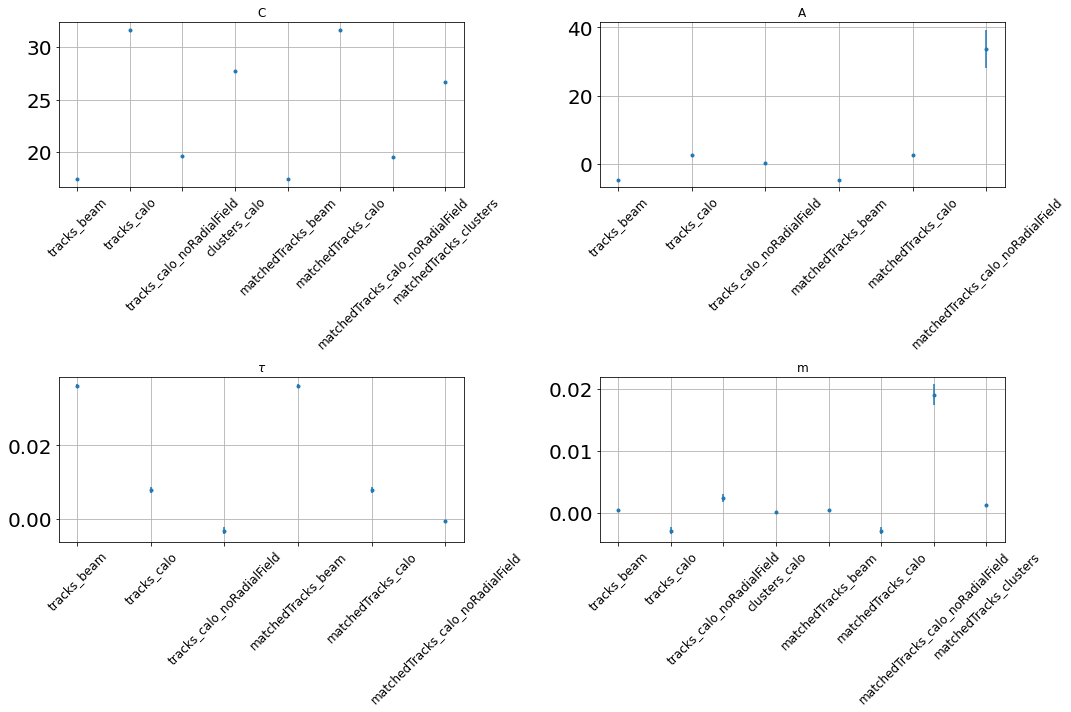

In [56]:
fig,axs = plt.subplots(int(len(parDict)/2),2,figsize=(15,10), sharex=False)
if(len(parDict) > 2):
    ax = flatten2dArray(axs)
else:
    ax = axs

for i, name in enumerate(parDict):
    axi = ax[i]
    thispar = parDict[name]
    axi.errorbar(histNames[name], thispar, yerr=parErrDict[name], fmt=".")
    axi.grid()
    axi.set_title(name)
    plt.sca(axi)
    plt.xticks(rotation=45, fontsize=12,)
plt.tight_layout()
plt.show()

m


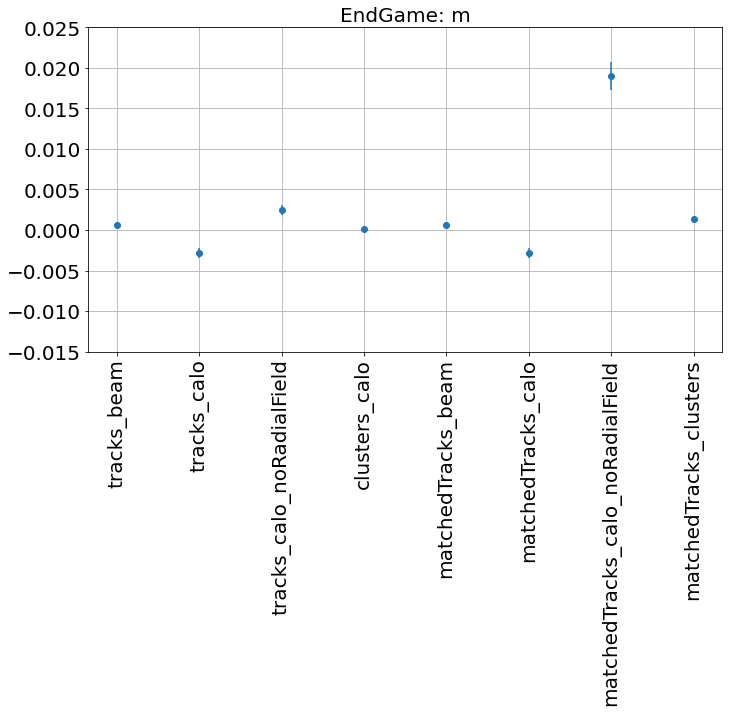

In [65]:
name = allNames[0][3]
print(name)
fig,ax = plt.subplots(figsize=(10,10))
axi = ax
thispar = parDict[name]
#axi.plot(histNames[name], thispar,".")
axi.errorbar(histNames[name], thispar, yerr=parErrDict[name], fmt="o")
axi.grid()
axi.set_title(dataset+": "+name,fontsize=20)
plt.sca(axi)
plt.xticks(rotation=90,)
plt.tight_layout()
plt.ylim(-0.015,0.025)
#plt.ylim(-0.015,0.025)
#plt.ylim(-0.02,0.04)
#plt.ylim(-0.015,0.025)
plt.show()